In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import math
import scipy.stats as stats
from tqdm import tqdm 
import time
import multiprocessing as mp

### Explorando IA Generativa em um Pipeline de ETL 

 - Extrair, transformar e carregar dados. 

**Projeto 1 do BootCamp Santander 2023 (Data Science)**

##### Plano:
 - Consumir o endpoint (GET https://sdw-2023-prd.up.railway.app/users/{id}) (API do Santander) p obter dados de cada cliente.
 - Usar API do ChatGPT para gerar uma mensagem de marketing personalizada para cada cliente.
 - Enviar as mensagens de volta API atualizando a lista de "news" de cada usuário.

> Pipeline nos vídeos

#### Extração:

In [2]:
#Repositorio API: https://github.com/digitalinnovationone/santander-dev-week-2023-api
sdw2023_api_url = 'https://sdw-2023-prd.up.railway.app'

In [3]:
df = pd.read_csv('SDW2023.csv')
user_ids = df['User ID'].tolist()
print(user_ids)

[1251, 3146, 3147, 3148]


In [4]:
# Obtendo os dados de cada ID pela API da Santander
import requests
import json

def get_user(id):
    response = requests.get(f'{sdw2023_api_url}/users/{id}')
    return response.json() if response.status_code == 200 else None

#Status 200 significa que a tentativa foi bem sucedida. Outro status indica algum erro na busca dos dados.

user = [user for id in user_ids if (user := get_user(id)) is not None] #compreensão de listas
#Só iremos atribuir os dados do usuario se ele não for None (evitar adicionai elemento None na lista)
print(json.dumps(user, indent= 2))

[
  {
    "id": 3146,
    "name": "Laidler",
    "account": {
      "id": 3323,
      "number": "12222-2",
      "agency": "2222",
      "balance": 1000.0,
      "limit": 3000.0
    },
    "card": {
      "id": 3044,
      "number": "xxxx xxxx xxxx 1222",
      "limit": 500.0
    },
    "features": [],
    "news": []
  },
  {
    "id": 3147,
    "name": "Jack",
    "account": {
      "id": 3324,
      "number": "13333-3",
      "agency": "3333",
      "balance": 4500.0,
      "limit": 3000.0
    },
    "card": {
      "id": 3045,
      "number": "xxxx xxxx xxxx 3332",
      "limit": 1500.0
    },
    "features": [],
    "news": []
  },
  {
    "id": 3148,
    "name": "Teuzinho",
    "account": {
      "id": 3325,
      "number": "14444-4",
      "agency": "4444",
      "balance": 14500.0,
      "limit": 300000.0
    },
    "card": {
      "id": 3046,
      "number": "xxxx xxxx xxxx 4444",
      "limit": 5500.0
    },
    "features": [],
    "news": []
  }
]


#### Transformação:

In [5]:
#Utilizando API do OpenAI GPT
import openai
openai.api_key = 's428EFgZKDH*****************Dmb0H7ZfYxxxxxxxxxxE' #ov

In [6]:
def generate_ai_news(us):
    completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo-0301",
  messages=[
    {"role": "system", "content": "Você é um especialista em Marketing bancário."},
    {"role": "user", "content": 'Crie uma mensagem personalizada para '+ str(us['name'])+ ', sobre a importância dos investimentos (máximo de 100 caracteres).'}
  ]
)
    time.sleep(20) #Limite de 3 msg por minuto no plano gratuito
    return completion.choices[0].message.content.strip('\"')

for us in user:
    news = generate_ai_news(us)
    us['news'].append({"description": news})
    print(news)

Invista no seu futuro financeiro com Laidler.
Jack, invista em seu futuro! #mudandovidascominvestimentos
Teuzinho, invista no seu futuro! 💰


#### Carregamento:

In [7]:
def update_user(user):
    response = requests.put(f"{sdw2023_api_url}/users/{user['id']}", json = user)
    return True if response.status_code == 200 else False

In [8]:
for us in user:
    success = update_user(us)
    print(f"{us['name']} updated? {success}!")

Laidler updated? True!
Jack updated? True!
Teuzinho updated? True!


> Pipeline feito por mim

Extrair, Transformar e Carregar no contexto da análise de Fundos Imobiliários!

### Preparação

In [9]:
# Importando Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm 
import time
import multiprocessing as mp
import random
import datetime
import yfinance as yf
import mplcyberpunk
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
import time
from selenium import webdriver
from selenium.webdriver.firefox.service import Service as FirefoxService
from webdriver_manager.firefox import GeckoDriverManager
import datetime
import pandas_datareader.data as pdr
from numpy import linalg as LA
import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
import os
from pathlib import Path
yf.pdr_override()

#Funções utilizadas:
def encontrar_arquivo_download(nome_arquivo):
    # Encontra o caminho da pasta de download padrão
    if os.name == "nt":  # Windows
        pasta_download = Path(os.path.expanduser("~")) / "Downloads"
    elif os.name == "posix":  # Linux ou macOS
        pasta_download = Path(os.path.expanduser("~")) / "Downloads"
    else:
        raise OSError("Sistema operacional não suportado.")
    
    # Verifica se o arquivo está presente na pasta de download
    arquivo_procurado = pasta_download / nome_arquivo
    if arquivo_procurado.is_file():
        return str(arquivo_procurado)
    else:
        return None

def BolaDeNeve(data):
    '''Docstring:
        Função recebe Data Frame e retorna valores para calcularmos o Magic Number necessário para
        começar a 'bola de neve'. Ou seja, a quantidade de cotas e a quantidade de investimento necessario
        para que a rentabilidade pague +1 cota.    
    '''
    cotas=[]
    valores=[]
    for i in range(1,len(data)+1):
        preco = data.loc[i]['Preco']
        div_ult = data.loc[i]['Ultimo Dividendo']
        cotas_nec = round(preco/div_ult)
        valor_nec = cotas_nec*preco
        cotas.append(cotas_nec)
        valores.append(valor_nec)
    return cotas,valores


### Extrair

Iremos extrair os dados do csv previamente carregado, do yahoo finance e Alpha Vantage.

In [14]:
#Procurando dados Ibovespa e IFIX (no momento os dados de IFIX n podem ser baixados pelo yfinance)
codigos = ["^BVSP","IFIX.SA"] #Ibovespa e IFIX
data_final = pd.Timestamp.today()
data_inicial = data_final - pd.DateOffset(months=12) #dados do ultimo ano
dados_mercado = yf.download(codigos, data_inicial, data_final, ignore_tz=True)['Adj Close']

###Necessário outra API para puxar IFIX:
ALPHA_VANTAGE_KEY = "7JAS31B6R89N7FA8" #Codigo adquirido ao me registrar
ts = TimeSeries(key=ALPHA_VANTAGE_KEY,output_format='pandas')
ts.get_daily("IFIX.SAO") #Versão gratuita
dados_ifix, meta = ts.get_daily("IFIX.SAO",outputsize='full') #separando os dados necessarios

[*********************100%***********************]  2 of 2 completed


In [27]:
tabela_dwnl = pd.read_csv("statusinvest-busca-avancada.csv",                 #error_bad_lines=False
                          sep=';', comment='#', na_values=' ')

In [30]:
print(dados_ifix, dados_mercado, tabela_dwnl)

              1. open    2. high     3. low   4. close  5. volume
date                                                             
2023-09-22  3224.2400  3231.0300  3224.2400  3226.3899        0.0
2023-09-21  3224.7000  3230.1101  3221.9800  3224.2400        0.0
2023-09-20  3229.5200  3233.4500  3224.0200  3224.7000        0.0
2023-09-19  3233.3701  3239.7200  3227.2800  3229.5200        0.0
2023-09-18  3234.0901  3235.6299  3228.3201  3233.3799        0.0
...               ...        ...        ...        ...        ...
2013-01-15  1584.9600  1587.1300  1581.5900  1583.7600        0.0
2013-01-14  1587.2200  1588.4600  1582.7000  1584.4500        0.0
2013-01-11  1589.8700  1590.0300  1583.6600  1587.2100        0.0
2013-01-10  1587.9600  1590.7700  1584.3000  1589.8700        0.0
2013-01-09  1587.8300  1590.0100  1582.0500  1587.9600        0.0

[2654 rows x 5 columns]                 IFIX.SA          ^BVSP
Date                                  
2022-09-26          NaN  109114.000000


### Transformar

* Organizando os dados do ifix e ibovespa de acordo com a forma mais conveniente (analisar anualmente e mensalmente). 

In [19]:
#Dados anuais (ifix):
ifix_anual = dados_ifix['4. close'].resample("Y").last() #pegando dados anuais do IFIX
media_anual = dados_ifix['4. close'].resample("Y").mean()
#calcular fechamento do dia, retorno no ano dos ativos
retorno_anual_ifix = ifix_anual.pct_change() #funcao que automatiza isso
retorno_anual_ifix = retorno_anual_ifix.dropna()

#Dados mensais (ifix):
ifix_mensal = dados_ifix['4. close'].resample("M").last() # Pegando dados mensais do IFIX
retorno_mensal_ifix = ifix_mensal.pct_change().dropna()

ifix =  dados_ifix['4. close'][:150]

ibov = dados_mercado['^BVSP'].sort_index(ascending = False)

#Dados anuais (IBOVESPA):
ibov_anual = ibov.resample("Y").last() #pegando dados anuais do IBOVESPA
media_anual = ibov.resample("Y").mean()
#calcular fechamento do dia, retorno no ano dos ativos
retorno_anual_ibov = ibov_anual.pct_change()
retorno_anual_ibov = retorno_anual_ibov.dropna()

#Dados mensais (IBOVESPA):
ibov_mensal = ibov.resample("M").last() #pegando dados anuais do IBOVESPA
media_mensal = ibov.resample("M").mean()
#calcular fechamento do dia, retorno no ano dos ativos
retorno_mensal_ibov = ibov_mensal.pct_change()
retorno_mensal_ibov = retorno_mensal_ibov.dropna()

In [21]:
#Guardando tudo em Data Frame:
df_ibov = pd.DataFrame(data=ibov)
df_ifix = pd.DataFrame(data=ifix)
df_ifix.rename(columns = {'5. adjusted close':'IFIX.SA'}, inplace=True)

In [23]:
df_ibov

,^BVSP
Date,
2023-09-22,116008.640625
2023-09-21,116145.000000
2023-09-20,118695.000000
2023-09-19,117846.000000
2023-09-18,118288.000000
...,...
2022-09-30,110037.000000
2022-09-29,107664.000000
2022-09-28,108451.000000


In [24]:
df_ifix

,4. close
date,
2023-09-22,3226.3899
2023-09-21,3224.2400
2023-09-20,3224.7000
2023-09-19,3229.5200
2023-09-18,3233.3799
...,...
2023-02-24,2803.1101
2023-02-23,2793.4900
2023-02-22,2797.8501


* Limpando e filtrando a tabela csv

In [31]:
tabela_dwnl.DY = tabela_dwnl.DY.str.replace(".","").str.replace(",",".").astype(float)
tabela_dwnl['P/VP'] = tabela_dwnl['P/VP'].str.replace(".","").str.replace(",",".").astype(float)
tabela_dwnl['PATRIMONIO'] = tabela_dwnl['PATRIMONIO'].str.replace(".","").str.replace(",",".").astype(float)
tabela_dwnl['ULTIMO DIVIDENDO'] = tabela_dwnl['ULTIMO DIVIDENDO'].str.replace(".","").str.replace(",",".").astype(float)
tabela_dwnl['PRECO'] = tabela_dwnl['PRECO'].str.replace(".","").str.replace(",",".").astype(float)

<ipython-input-31-d9f2a8e39d53>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tabela_dwnl.DY = tabela_dwnl.DY.str.replace(".","").str.replace(",",".").astype(float)
<ipython-input-31-d9f2a8e39d53>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tabela_dwnl['P/VP'] = tabela_dwnl['P/VP'].str.replace(".","").str.replace(",",".").astype(float)
<ipython-input-31-d9f2a8e39d53>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tabela_dwnl['PATRIMONIO'] = tabela_dwnl['PATRIMONIO'].str.replace(".","").str.replace(",",".").asty

In [32]:
tabela_dwnl

,TICKER,PRECO,ULTIMO DIVIDENDO,DY,VALOR PATRIMONIAL COTA,P/VP,LIQUIDEZ MEDIA DIARIA,PERCENTUAL EM CAIXA,CAGR DIVIDENDOS 3 ANOS,CAGR VALOR CORA 3 ANOS,PATRIMONIO,N COTISTAS,GESTAO,N COTAS
0,ABCP11,67.39,0.500000,8.41,"91,88",0.73,"72.120,89","1,59","13,18","-5,20",4.326613e+08,"17.747,00",Passiva,"4.709.082,00"
1,AFHI11,97.62,1.050000,12.83,"95,83",1.02,"1.160.677,24","9,42",NaN,NaN,3.203778e+08,"23.891,00",Ativa,"3.343.095,00"
2,AIEC11,68.40,0.760000,13.27,"94,79",0.72,"714.338,92","2,54","9,48",NaN,4.573551e+08,"15.564,00",Ativa,"4.824.987,00"
3,ALMI11,736.00,0.371133,0.00,"2.033,68",0.36,"46.322,49","2,39",NaN,"-14,61",2.260984e+08,"2.338,00",Passiva,"111.177,00"
4,ALZC11,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1.000.000,00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,XPPR11,22.00,0.100000,10.00,"70,31",0.31,"355.919,05","3,55","-30,77","-36,07",5.144320e+08,"60.101,00",Ativa,"7.316.171,00"
467,XPSF11,8.52,0.075000,10.75,"8,75",0.97,"578.835,81","2,40","0,78","-4,03",3.789740e+08,"47.223,00",Ativa,"43.302.140,00"
468,YUFI11,88.90,0.383187,3.70,"101,66",0.87,"149,00","8,94",NaN,NaN,5.008454e+07,"56,00",Ativa,"492.650,00"
469,ZAVI11,129.18,1.160000,9.54,"135,32",0.95,"523.192,32","5,73",NaN,NaN,1.587796e+08,"3.838,00",Ativa,"1.173.322,00"


In [33]:
### Filtro ditado por mim
minimo_DY = 4.0 #Valor mínimo para Dividend Yield
maximo_DY = 16.0 #Valor maximo dividend Yield
valor_max = 1.1 #Valor maximo da relação patrimonial

Filtro_DY = tabela_dwnl[(tabela_dwnl.DY >= minimo_DY)*(tabela_dwnl.DY < maximo_DY)] # Aqueles com DY entre 6 e 10
Filtro = Filtro_DY[Filtro_DY['P/VP'] <= valor_max] #Aqueles com valor de cota menor ou igual ao valor patrimonial
Filtro = Filtro.sort_values(by=['PATRIMONIO'], ascending=False).dropna() 

#####Após o filtro, manipularemos os dados para fins de conveniencia:
#Renomeando colunas + selecionando as 15 cotas mais interessantes
df_2 = pd.DataFrame(data = Filtro[1:16].values,index = list(range(1,16)),columns = ['Ticker','Preco','Ultimo Dividendo','DY','VALOR PATRIMONIAL COTA','P/VP','LIQUIDEZ MEDIA DIARIA','PERCENTUAL EM CAIXA','Dividendos 3 anos','Valor CORA 3 anos','PATRIMONIO','COTISTAS','GESTAO','N COTAS'])
#Adicionando rentabilidade do ultimo mês como uma coluna nova
df_2['% ult mês'] = (df_2['Ultimo Dividendo']/df_2['Preco'])*100
#Adicionando o Magic Number como uma coluna nova
df_2['Cotas Necessarias'],df_2['Investimento Necessario (Real)'] = BolaDeNeve(df_2)
#Ordenando pelo menor valor necessário para alcançar o Magic Number
df_2 = df_2.sort_values(by=['Investimento Necessario (Real)'])

### Criando as duas seleções de escolha de ativos:
## 1° : Os 5 melhores magic numbers
MN_5_melhores = df_2[:5]
## 2°: Os 5 melhores rendimentos do ultimos mês
# Ordenando de acordo com a rentabilidade SEGUNDO O ULTIMO DIVIDENDO
df_2 = df_2.sort_values(by=['% ult mês'], ascending=False)
Rent_5_melhores = df_2[:5]

print("Testando uma carteira de fundos imobiliário com os ativos: "+str(MN_5_melhores['Ticker'].tolist())+" e "+str(Rent_5_melhores['Ticker'].tolist()))

Testando uma carteira de fundos imobiliário com os ativos: ['MXRF11', 'KNCR11', 'IRDM11', 'BRCR11', 'CPTS11'] e ['KNCR11', 'MXRF11', 'IRDM11', 'CPTS11', 'HGBS11']


In [36]:
#Selecionando os Tickers dos nossos ativos:
escolhas = MN_5_melhores['Ticker'].tolist() + Rent_5_melhores['Ticker'].tolist()
escolhas = list(dict.fromkeys(escolhas))


##Buscar dados para simulações de Monte Carlo:
lista_acoes = escolhas #pegando os fundos que escolhemos
lista_acoes = [fii + ".SA" for fii in lista_acoes] #para conseguir puxar os dados da yfinance

data_final = pd.Timestamp.today()
data_inicial = data_final - pd.DateOffset(months=110) #pegar dados desde 2014
precos = yf.download(lista_acoes, start=data_inicial, end=data_final)['Adj Close']

[*********************100%***********************]  6 of 6 completed


In [37]:
#Informações sobre o retorno da nossa carteira no momento
retornos = precos.pct_change().dropna()
media_retornos = retornos.mean()
matriz_covariancia = retornos.cov()
pesos_carteira = np.full(len(lista_acoes), 1/len(lista_acoes))
numero_acoes = len(lista_acoes)

In [38]:
retornos

,BRCR11.SA,CPTS11.SA,HGBS11.SA,IRDM11.SA,KNCR11.SA,MXRF11.SA
Date,,,,,,
2020-06-05,0.024061,0.007845,0.012253,-0.014607,-0.001080,0.000000
2020-06-08,0.005292,-0.003632,0.009776,0.011753,0.000432,0.002740
2020-06-09,0.013371,0.001042,0.012817,-0.001734,0.013941,-0.000911
2020-06-10,0.010909,0.000832,0.010606,-0.003908,-0.007887,0.000911
2020-06-12,0.006886,-0.003743,0.008964,0.000872,-0.000860,-0.010018
...,...,...,...,...,...,...
2023-09-18,0.008939,0.014102,0.008079,0.015810,-0.000200,-0.001799
2023-09-19,-0.002215,0.001780,-0.001516,0.011388,-0.004109,-0.018018
2023-09-20,-0.004281,0.003776,-0.001085,0.011760,0.002617,0.007339


Text(0.5, 0, 'Dias')

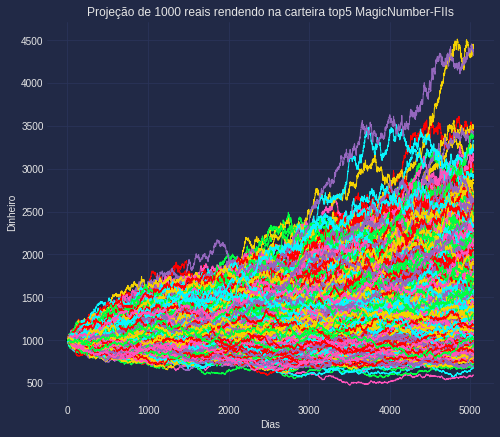

In [39]:
#### Simulações:
# Premissas montecarlo

numero_simulacoes = 1000
dias_projetados = 252*20 #252 dias uteis -> proximos 20 anos
capital_inicial = 1000 #o que vai ocorrer com 1000 reais?

#Retorno medio em forma de matriz

retorno_medio = retornos.mean(axis = 0).to_numpy()
matriz_retorno_medio = retorno_medio*np.ones(shape = (dias_projetados,numero_acoes))

#Nossa matriz L

L = LA.cholesky(matriz_covariancia)

retornos_carteira = np.zeros([dias_projetados, numero_simulacoes])
montante_final = np.zeros(numero_simulacoes)

for s in range(numero_simulacoes):
    
    Rpdf = np.random.normal(size = (dias_projetados, numero_acoes))
    retornos_sinteticos = matriz_retorno_medio + np.inner(Rpdf, L) #Unico parametro aleatorio é Rpdf
    
    retornos_carteira[:,s] = np.cumprod(np.inner(pesos_carteira, retornos_sinteticos) + 1) * capital_inicial
    montante_final[s] = retornos_carteira[-1,s]

plt.figure(figsize = [8,7])
plt.title("Projeção de 1000 reais rendendo na carteira top5 MagicNumber-FIIs")
plt.plot(retornos_carteira,linewidth = 1)
plt.ylabel('Dinheiro')
plt.xlabel('Dias')

In [41]:
#Criando as estatísticas para a nossa análise de carteira

montante_99 = str(np.percentile(montante_final,1))
montante_95 = str(np.percentile(montante_final,5))
montante_mediano = str(np.percentile(montante_final, 50))
cenarios_com_lucro = str(round((len(montante_final[montante_final > 1000])/len(montante_final))*100,2))+"%"

print("Ao investir R$ 1000,00 na carteira " + str(lista_acoes), "o resultado esperado para as próximas duas décadas, seguindo o método Monte Carlo com 1.000 simulações: \n")
print("50% de chance do montante ser maior que R$"+str(montante_mediano))
print("95% de chance do montante ser maior que R$"+str(montante_95))
print("99% de chance do montante ser maior que R$"+str(montante_99))
print("Cenários com lucro: "+str(cenarios_com_lucro))

Ao investir R$ 1000,00 na carteira ['MXRF11.SA', 'KNCR11.SA', 'IRDM11.SA', 'BRCR11.SA', 'CPTS11.SA', 'HGBS11.SA'] o resultado esperado para as próximas duas décadas, seguindo o método Monte Carlo com 1.000 simulações: 

50% de chance do montante ser maior que R$1454.1651102531464
95% de chance do montante ser maior que R$891.6702439247139
99% de chance do montante ser maior que R$750.0899925457575
Cenários com lucro: 89.4%


### Carregar

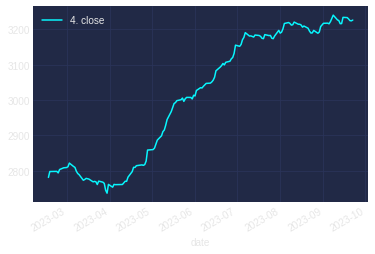

In [25]:
#Save_plot:
plt.style.use('cyberpunk')
df_ifix.plot()
plt.savefig('IFIX.png', dpi = 300)
plt.show()

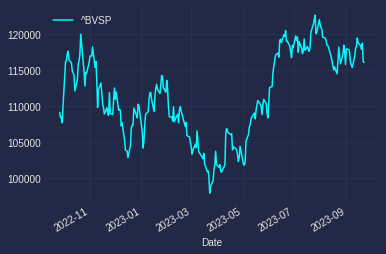

In [26]:
#Save_plot:
plt.style.use('cyberpunk')
df_ibov.plot()
plt.show()

In [34]:
#Criando planilha dos ativos escolhidos:
df_escolhas = pd.concat([MN_5_melhores, Rent_5_melhores], ignore_index=True).drop_duplicates()
df_escolhas.to_excel("carteira_ifix.xlsx") 

In [40]:
#salvar a imagem
plt.savefig('proj.png', dpi = 300)

plt.show()

<Figure size 432x288 with 0 Axes>

Receber a análise via e-mail:

In [60]:
#### Envio de e-mail (gmail):

fromaddr = "hutakegames@gmail.com" #Email de teste. Mude para um seu.
remetentes = str(input("Digite seu e-mail (para mais de um, separe por virgula): ")).split(',')
toaddr = " , ".join(remetentes)
msg = MIMEMultipart()
msg['From'] = fromaddr
msg['To'] = toaddr
msg['Subject'] = "Relatorio Automático FIIs."
body = f''' 
    Prezado,
    
    Segue a análise dos melhores fundos imobiliários com respeito ao Magic Number (aqueles que necessitam menor investimento para pagarem as proprias cotas).
    
    As cotas escolhidas para a carteira foram {lista_acoes}. 
    Com essa carteira, a chance de ter lucro nos próximos 20 anos será de {cenarios_com_lucro}. 
    Com R$1.000,00 investidos, haverá 50% de chance do montante ser maior que {montante_mediano} e 95% de chance do montante ser maior que {montante_95}.
    
    O rendimento mensal do IFIX: {round(retorno_mensal_ifix[-1],2)}%.
    O rendimento anual do IFIX: {round(retorno_anual_ifix[-1],2)}%.
    
    O rendimento mensal do IBOVESPA: {round(retorno_mensal_ibov[-1],2)}%.
    O rendimento anual de IBOVESPA: {round(retorno_anual_ibov[-1],2)}%.
    
    Segue em anexo os gráficos que mostram as possíveis evoluções destes rendimentos seguindo o método Monte Carlo.
    
    Abraços!
    
    
    Robô Hutake, auxiliar de Thiago Laidler (astrofísico e cientista de dados).
    Prazer.
    '''
msg.attach(MIMEText(body, 'plain'))

filename = "proj.png"
attachment = open("proj.png", "rb")

filename2 = "IFIX.png"
attachment2 = open("IFIX.png", "rb")

filename3 = "carteira_ifix.xlsx"
attachment3 = open("carteira_ifix.xlsx", "rb")

p = MIMEBase('application', 'octet-stream')
p.set_payload((attachment).read())
encoders.encode_base64(p)
p.add_header('Content-Disposition', "attachment; filename= %s" % filename)
msg.attach(p)
p2 = MIMEBase('application', 'octet-stream')
p2.set_payload((attachment2).read())
encoders.encode_base64(p2)
p2.add_header('Content-Disposition', "attachment2; filename= %s" % filename2)
msg.attach(p2)
p3 = MIMEBase('application', 'octet-stream')
p3.set_payload((attachment3).read())
encoders.encode_base64(p3)
p3.add_header('Content-Disposition', "attachment3; filename= %s" % filename3)
msg.attach(p3)

s = smtplib.SMTP('smtp.gmail.com', 587)
s.starttls()
s.login(fromaddr, "xxl*****xfv*****v") #Depende da password para apps do seu gmail
text = msg.as_string()
s.sendmail(fromaddr, remetentes, text)

s.quit()

Digite seu e-mail (para mais de um, separe por virgula): thithicu@gmail.com, thiago18@ov.ufrj.br


(221,
 b'2.0.0 closing connection e3-20020a170902b78300b001befac3b3cbsm7508592pls.290 - gsmtp')